In [ ]:
# import pytorch libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import cv2
from PIL import Image, ImageOps
from sklearn.metrics import f1_score
from scipy import stats
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import AlexNet
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


model_alex = AlexNet() # could see if this works

# import for visualisation of network
!pip install graphviz
!pip install torchviz


import graphviz
import torchviz

     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=864253babd2aa106df511e074dc8ecc14b7c23129059e034c7dd6f3506ca3cdd
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [ ]:
# use GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) # if on CUDA machine -> should print a CUDA device:
!nvidia-smi  # tells you what GPU you're on

cpu
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# change path to correct folder 

from google.colab import drive
drive.mount('/content/gdrive')
PATH_OF_DATA= '/content/gdrive/"My Drive"/data/chest_xray' # see content of dataset
!ls {PATH_OF_DATA} # datasets.ImageFolder() expects data as root/label/picture.png

Mounted at /content/gdrive
test  train  val


In [ ]:
# custom dataset class for the images and masks

import cv2
import random
import sklearn
import skimage.transform as tr
import skimage
from PIL import Image
from numpy import asarray
from skimage import io, transform


class Resize(object):

  def __init__(self, width, height):
      self.width = width
      self.height = height
                          
  def __call__(self, image):
      image = asarray(image)
      width = self.width
      height = self.height

      image = skimage.transform.resize(image, (width, height), preserve_range=True, anti_aliasing=True )

      return image

class Normalise(object):  
  """ Normalise CT scan in the desired examination window
      takes in image as numpy """
  
  def __init__(self, level, window):
      self.level = level
      self.window = window
                          
  def __call__(self, image):
      # image
      minval = self.level - self.window/2
      maxval = self.level + self.window/2
      #print(image[0][160][160][0])
      #print(image[0][160][160][1])
      #print(image[0][160][160][2])
      img_norm = np.clip(image, minval, maxval)
      img_norm -= minval
      img_norm /= self.window
      return img_norm

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose(2,0,1)
        image = torch.from_numpy(image).float() # dont know why images/mask casted to float here but need to do it again later
        return image

class HorizontalFlip(object):
  """ Flip images """
  def __call__(self,image):
    if random.random() <= 0.5:
      transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1)])
      image = transform(image)
    return image

class Rotation(object):  
  """ Random rotate images """
  def __call__(self,image):
    if random.random() <= 0.5:
      if random.random() <= 0.5:
        image = tr.rotate(image, 10)
      else:
        image = tr.rotate(image,  -10)
    return image


class Shifting(object): 
  """ Random shift images """
  def __call__(self,image):
    if random.random() <= 0.5:
      if random.random() <= 0.5:
        transform = tr.AffineTransform(translation = (-30,20))
        image = tr.warp(image,transform) # default is padding with zeros
      else:
        transform = tr.AffineTransform(translation = (10,-30))
        image = tr.warp(image,transform) # default is padding with zeros
    return image

class Noise(object):  # helps prevent overfitting
  """ Random noise images """
  def __call__(self,image):
    if random.random() <= 0.5:
      image = skimage.util.random_noise(image, var = 0.000001)
      # would this work given that mask is unchanged??
    return image

class GaussBlur(object):  # helps prevent overfitting
  """ Gaussian blur images """
  def __call__(self,image):
    if random.random() <= 0.5:
      image = cv2.GaussianBlur(image,(3,3),0)
      # do i want to blur the mask??
    return image

import math

class RandomErasing(object):
    '''
    Class that performs Random Erasing in Random Erasing Data Augmentation by Zhong et al. 
    -------------------------------------------------------------------------------------
    probability: The probability that the operation will be performed.
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio
    mean: erasing value
    -------------------------------------------------------------------------------------
    '''
    def __init__(self, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0, 0, 0]):
        self.probability = probability
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.probability:
            return img

        for attempt in range(100):
            #print('height', img.shape[0])
            #print('width', img.shape[1])
            area = img.shape[0] * img.shape[1]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.shape[1] and h < img.shape[0]:
                x1 = random.randint(0, img.shape[1] - w)
                y1 = random.randint(0, img.shape[0] - h)
                if img.shape[2] == 3:
                    img[y1:y1+w, x1:x1+h,  0] = self.mean[0]
                    img[y1:y1+w, x1:x1+h,  1] = self.mean[1]
                    img[y1:y1+w, x1:x1+h,  2] = self.mean[2]
                else:
                    img[x1:x1+h, y1:y1+w, 0] = self.mean[0]
                return img

        return img

In [ ]:
# GaussBlur(),Noise(),
# ,transforms.RandomPerspective(distortion_scale=0.3, p=0.5), totensor, transforms.RandomErasing(p=0.5, scale=(0.05, 0.2), ratio=(0.1, 0.6), value=0, inplace=False)
transform_test = transforms.Compose([Resize(320,320),ToTensor()])
transform_train = transforms.Compose([Resize(320,320), RandomErasing(),  Rotation(),  ToTensor(), HorizontalFlip()]) # 175 150

trainset = torchvision.datasets.ImageFolder(root= "/content/gdrive/My Drive/data/chest_xray/train", transform = transform_train)
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 32, shuffle = True, num_workers = 0)

testset = torchvision.datasets.ImageFolder(root="/content/gdrive/My Drive/data/chest_xray/test", transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

valset = torchvision.datasets.ImageFolder(root= "/content/gdrive/My Drive/data/chest_xray/val", transform = transform_test)
valloader = torch.utils.data.DataLoader(valset, batch_size = 32, shuffle = True, num_workers = 0)


In [ ]:
# if want to further split training data

train_size_1 = int(0.97 * len(trainset))
train_size_2 = len(trainset) - train_size_1
train_dataset_1, train_dataset_2 = torch.utils.data.random_split(trainset, [train_size_1, train_size_2])
trainloader_dataset_1 = torch.utils.data.DataLoader(train_dataset_1,batch_size = 32, shuffle = True, num_workers = 0)
trainloader_dataset_2 = torch.utils.data.DataLoader(train_dataset_2,batch_size = 32, shuffle = True, num_workers = 0)


# i.e. to overfit to small subset of trainset use train_dataset_1


In [ ]:
# Need to see how it matches up labels
print(trainset.class_to_idx)
print(testset.class_to_idx)
print(valset.class_to_idx)

# Make sure this matches up order
classes = ('Normal','Pneumonia')

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
# Plot two images from training data and labels

import matplotlib.pyplot as plt
for k in range(20):
  examples = enumerate(trainloader) # trainloader = full trainset, trainloader_dataset_2 = small sample of trainset )
  batch_idx, (example_data, example_targets) = next(examples)
  #print(example_data.shape)
  #print(example_targets.shape)c
  #print(batch_idx)
  for i in range(32):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(example_data[i,0], cmap = 'Greys_r', vmin=example_data[i,0].min(), vmax=example_data[i,0].max())
    plt.show()
    print(classes[example_targets[0]])
  # can see that first index of [a,b] i.e. a details the number in the batch


In [ ]:
# define your neural network model

class neural_net(nn.Module):
  def __init__(self):
    super(neural_net,self).__init__()
    
    self.pool = nn.MaxPool2d(3,3) # define pool as max 2x2
    
    self.dropout1 = nn.Dropout2d(p=0.2) # spatial dropout
    self.dropout2 = nn.Dropout2d(p=0.5)

    self.relu = nn.LeakyReLU()
    self.softmax = nn.Softmax()
    self.swish = nn.Hardswish()
    self.adpool = nn.AdaptiveAvgPool2d(((1,1)))

    self.conv1 = nn.Conv2d(3,16,3,padding =1) # i.e. input channel, output channels, Kernel size
    self.batch1 = nn.BatchNorm2d(16) # batch normalisation

    self.conv2 = nn.Conv2d(16,32,3, padding = 1)
    self.batch2 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(32,64,3, padding = 1)
    self.batch3 = nn.BatchNorm2d(64)

    self.conv4 = nn.Conv2d(64,128,3, padding = 1)
    self.batch4 = nn.BatchNorm2d(128)

    self.fc1 = nn.Linear(in_features = 128*3*3, out_features = 64) # pool
    self.fc2 = nn.Linear(in_features = 64, out_features = 16)
    self.out = nn.Linear(in_features = 16, out_features = 2)
  
  def forward(self,x):
    x = self.relu(self.pool(self.batch1(self.conv1(x))))
    x = self.relu(self.pool(self.batch2(self.conv2(x))))
    x = self.relu(self.pool(self.batch3(self.conv3(x))))
    x = self.relu(self.pool(self.batch4(self.conv4(x))))
    #x = self.dropout1(x)
    print(x.shape)
    x = x.view(-1,128*3*3)  
    
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.out(x)
    return x



class UNET(nn.Module): # need to add bottleneck
    def __init__(self, in_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 16, 3, 1)
        self.conv2 = self.contract_block(16, 32, 3, 1)
        self.conv3 = self.contract_block(32, 32, 3, 1)
        self.conv4 = self.contract_block(32, 32, 3, 1)
        self.dropout = nn.Dropout2d(p=0.5)
        self.pool = self.pooling_layer()

    
        self.relu = nn.ReLU()

        
        self.bottleneck = self.bottleneck_block(32, 64, 128, 3, 1)    
        
        self.fc1 = nn.Linear(in_features = 64*10*10, out_features = 64) # pool
        self.fc2 = nn.Linear(in_features = 64, out_features = 16)
        self.out = nn.Linear(in_features = 16, out_features = 2)


        # NOT FROM HERE
        """

        self.upconv4 = self.expand_block(128*2, 128, 3, 1)
        self.upscale_4 = self.upscale_layer(128)
        self.upconv3 = self.expand_block(128*2, 128, 3, 1)
        self.upscale_3 = self.upscale_layer(128)
        self.upconv2 = self.expand_block(128*2, 64, 3, 1)
        self.upscale_2 = self.upscale_layer(64)
        self.final_conv = self.final_block(64*2, out_channels, 3, 1)
        """
        # TO HERE

    def __call__(self, x):

        #print(x.shape)
        # downsampling part
        # encode the input image into feature representations at multiple different levels.
        conv1 = self.conv1(x)
        pool1 = self.pool(conv1)
        conv2 = self.conv2(pool1)
        drop1 = self.dropout(conv2)
        pool2 = self.pool(drop1)
        conv3 = self.conv3(pool2)
        drop2 = self.dropout(conv3)
        pool3 = self.pool(drop2)
        conv4 = self.conv4(pool3)
        drop4 = self.dropout(conv4)

        #print(x.shape)
  
        
        # bottleneck
        # force the model to learn a compression of the input data.
        # compressed view should only contain the “useful” information to
        # reconstruct the input (or segmentation map).
        pool4 = self.pool(drop4)
        y = self.bottleneck(pool4)
        #bottleneck2 = self.bottleneck(bottleneck1
        
        #print(y.shape)

        # chuck in pool layer here!!!
        y = self.pool(y)  

        y = y.view(-1,64*10*10)  

        #print(y.shape)
    
        y = self.relu(self.fc1(y))
        y = self.relu(self.fc2(y))
        y = self.out(y)
        # NOT FROM HERE


        """
        # expand block concatenate conv4 and bottleneck output


        upconv4 = self.upconv4(torch.cat([bottleneck1, conv4], 1))
        upscale_conv_4 = self.upscale_4(upconv4)
        upconv3 = self.upconv3(torch.cat([upscale_conv_4, conv3], 1))
        upscale_conv_3 = self.upscale_3(upconv3)
        upconv2 = self.upconv2(torch.cat([upscale_conv_3, conv2], 1))
        upscale_conv_2 = self.upscale_2(upconv2)
        final_layer = self.final_conv(torch.cat([upscale_conv_2, conv1], 1))

        # TO HERE
        """
        return y


    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
                            )
        return expand

    def bottleneck_block(self, in_channels, mid_channels, out_channels, kernel_size, padding):

      bottleneck = nn.Sequential(
          nn.Conv2d(in_channels, mid_channels, kernel_size = kernel_size, stride = 1, padding = padding),#, stride = 1, padding =1),
          nn.ReLU(),
          nn.BatchNorm2d(mid_channels),
          nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=1, padding=padding),
          nn.ReLU(),
          nn.BatchNorm2d(mid_channels),
          #nn.ConvTranspose2d(mid_channels, out_channels, kernel_size = 3, stride = 2, padding = 1, output_padding=1) #??
          )
      return bottleneck
    
    def pooling_layer(self):

      pool = nn.Sequential (
          nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      return pool

    def upscale_layer(self, channels):

      upscale = nn.Sequential(
          nn.ConvTranspose2d(channels, channels, kernel_size = 3, stride = 2, padding = 1, output_padding=1) #??
      )
      return upscale


    def final_block(self, in_channels, out_channels, kernel_size, padding):

        final_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return final_block



In [ ]:
# summary of neural net


#model = neural_net()
model = UNET(3)
#model.to(device) # send to GPU

from torchsummary import summary
data_input_shape = (3,320,320)
model.to(device)
summary(model, data_input_shape)

# visualise model
"""
x = (torch.randn(32,3,320,320))
x = x.to(device)
y = model(x)
torchviz.make_dot(y.mean(),params = dict(model.named_parameters()))
"""

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 320, 320]             448
       BatchNorm2d-2         [-1, 16, 320, 320]              32
              ReLU-3         [-1, 16, 320, 320]               0
            Conv2d-4         [-1, 16, 320, 320]           2,320
       BatchNorm2d-5         [-1, 16, 320, 320]              32
              ReLU-6         [-1, 16, 320, 320]               0
         AvgPool2d-7         [-1, 16, 160, 160]               0
            Conv2d-8         [-1, 32, 160, 160]           4,640
       BatchNorm2d-9         [-1, 32, 160, 160]              64
             ReLU-10         [-1, 32, 160, 160]               0
           Conv2d-11         [-1, 32, 160, 160]           9,248
      BatchNorm2d-12         [-1, 32, 160, 160]              64
             ReLU-13         [-1, 32, 160, 160]               0
        Dropout2d-14         [-1, 32, 1

'\nx = (torch.randn(32,3,320,320))\nx = x.to(device)\ny = model(x)\ntorchviz.make_dot(y.mean(),params = dict(model.named_parameters()))\n'

In [ ]:
# define hyperparameters

step = False # if false then will do cyclical
step_size_cyclical = 64

In [ ]:
# define the loss criterion and optimizer

if step == True: # step LR
  # learning_rate_step
  learning_rate_max = 0.1 #0.01
  learning_rate_min = 0.006
  epoch_range = 1
  step_size = 2
  gamma = 0.1 #np.exp((np.log(learning_rate_min)-np.log(learning_rate_max))/epoch_range)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr = learning_rate_max, momentum = 0.9, weight_decay = 0.01, nesterov = True) 
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma, last_epoch=-1)

if step == False: # cyclical LR
  learning_rate_max = 0.006
  learning_rate_min = 0.01
  epoch_range = 10
  step_size = step_size_cyclical
  gamma = np.exp((np.log(learning_rate_min)-np.log(learning_rate_max))/epoch_range)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr = learning_rate_max, momentum = 0.9, weight_decay = 0.0, nesterov = True) 
  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,  base_lr = learning_rate_min, max_lr = learning_rate_max, step_size_up = step_size) # default is 2000


In [ ]:
# adam optimizer

from torch.optim import lr_scheduler

weight = torch.tensor([0.9, 0.1]).to(device)
criterion = nn.CrossEntropyLoss(weight) # added weight
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay = 0.05) # use adam lr optimiser
scheduler = lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)

epoch_range = 10


In [ ]:
# want to be able to plot loss over time
validation_loss_vector_y = []
validation_loss_vector_x = []
training_loss_vector_x = []
training_loss_vector_y = []

# plot accuracy of test vs LR
learning_rate_vector = []
accuracy_test_vector = []

In [ ]:

# implement the training loop
import copy
train_overall_loss = 100 # arbitrary big number
val_running_loss = 100 # arbitrary big number
best_model_wts = copy.deepcopy(model.state_dict()) 


for epoch in range(epoch_range):
  running_loss = 0.0 
  for i, data in enumerate(trainloader,0): #trainloader = full trainset, trainloader_dataset_2 = small sample of trainset 
    # i is sets of images of batch size # data = [images, labels]
    #inputs, labels = data
    inputs, labels = data[0].to(device), data[1].to(device)
    model.train()
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    #print(outputs,labels)
    loss.backward()

    optimizer.step() # does the update
    scheduler.step()
    print('Current LR:', scheduler.get_last_lr()) 

    # if cyclical LR
    #if step == False:
    #  scheduler.step()
    #  print('Current LR:', scheduler.get_last_lr()) 
    # add to running loss
    running_loss += loss.item() 
    print('loss', loss.item())

    if i % 10 == 9: # every 10 batches of 64 images print running loss for training 
      # print statistics
      print('[%d,%5d] average loss for these 10 batches of 64 images is: %.3f' % (epoch + 1, i + 1 , running_loss/10))
      running_loss = 0
    
    # for plotting of loss of training set over time
    training_loss_vector_y.append(loss.item()) # vector of training losses
    training_loss_vector_x.append((i+1)*64/5216 + (epoch) ) # x axis is number of images

    
    if i % 10 == 9: # i.e. every 10 batches of 64 test on val set 
      # calculate loss on validation set
      val_loss = 0.0
      with torch.no_grad():
        for val_data in valloader: # i.e. iterate over batches of data in the val set
          val_images, val_labels = val_data[0].to(device), val_data[1].to(device) # each data is a batch of 1000 images/labels 
          model.eval()
          val_outputs = model(val_images)
          val_loss_mid = criterion(val_outputs,val_labels)
          val_loss += val_loss_mid.item()
          validation_loss_vector_y.append(val_loss)
          validation_loss_vector_x.append((i+1)*64/5216 + (epoch)) # generally x.append((i+1)*batchsize/number_of_training_images + (epoch)) gives x axis in units of epochs
          # need to save best version on validation set
          if (val_loss < val_running_loss):
            print('saving best model')
            model_save_name = 'model_best_on_val.pt'
            path = F"/content/gdrive/My Drive/Week 3/{model_save_name}" 
            torch.save(model.state_dict(), path)
            best_model_wts = copy.deepcopy(model.state_dict())
            val_running_loss = val_loss
      print('total loss for validation set is %.3f' % (val_loss) )
      print('Current LR:', scheduler.get_last_lr()) 

    # Decay step up Learning Rate
    #if step == True:
    #  scheduler.step()

    # print parameters
    #for name, param in model.named_parameters():  
    #  print(name,param)
print('Finished Training')


Current LR: [0.001]
loss 0.6406130790710449
Current LR: [0.001]
loss 0.6551884412765503
Current LR: [0.001]
loss 0.8831270933151245
Current LR: [0.001]
loss 0.6530943512916565
Current LR: [0.001]
loss 0.6795185804367065
Current LR: [0.001]
loss 0.6833865642547607
Current LR: [0.001]
loss 0.4947948157787323
Current LR: [0.001]
loss 0.48811256885528564
Current LR: [0.001]
loss 0.4489832818508148
Current LR: [0.001]
loss 0.5848028659820557
[1,   10] average loss for these 10 batches of 64 images is: 0.621
saving best model
total loss for validation set is 0.553
Current LR: [0.001]
Current LR: [0.001]
loss 0.479458749294281
Current LR: [0.001]
loss 0.44133445620536804
Current LR: [0.001]
loss 0.46755802631378174
Current LR: [0.001]
loss 0.8524996042251587
Current LR: [0.001]
loss 0.38475361466407776
Current LR: [0.001]
loss 0.6012782454490662
Current LR: [0.001]
loss 0.5299407839775085
Current LR: [0.001]
loss 0.7008882761001587
Current LR: [0.001]
loss 0.439866840839386
Current LR: [0.001

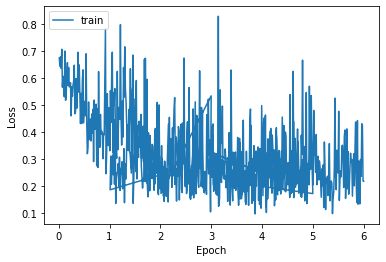

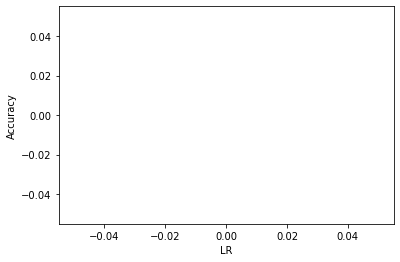

In [ ]:
# plot losses


plt.figure()
#plt.plot(validation_loss_vector_x,validation_loss_vector_y, label = "val")
plt.plot(training_loss_vector_x,training_loss_vector_y, label = "train")
z = np.polyfit(training_loss_vector_x,training_loss_vector_y, 2)
x = np.linspace(min(training_loss_vector_x),max(training_loss_vector_x),100)
#p = np.poly1d(z)
#plt.plot(x, p(x), label = "train_fit")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()



# plot accuracy vs learning rate - for setting LR

plt.figure()
plt.plot(learning_rate_vector,accuracy_test_vector)
plt.xlabel('LR')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
# save the model


model_save_name = 'final_model_report_03jan.pt'
path = F"/content/gdrive/My Drive/Week 3/{model_save_name}" 
torch.save(model.state_dict(), path)


NameError: ignored

In [ ]:
# load saved model

model_save_name = 'model_best_on_val.pt'
#model_save_name = 'final_model_report.pt'
path = F"/content/gdrive/My Drive/Week 3/{model_save_name}"
model.load_state_dict(torch.load(path, map_location = torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# load model immediately

model.load_state_dict(best_model_wts)


[[1281   60]
 [1090 2785]]


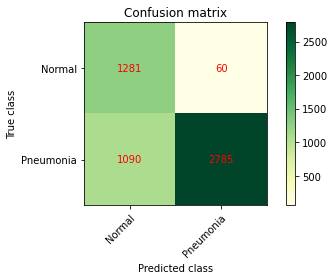

Class | Class Accuracy
Normal | 95.52572706935123
Pneumonia | 71.87096774193549


In [ ]:
# plot confusion matrix for training set



number_classes = 2

# initialise prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cuda')
lbllist=torch.zeros(0,dtype=torch.long, device='cuda')

with torch.no_grad(): # i.e. no point wasting time calculating gradient don't need it here
  for data in trainloader: # i.e. iterate over batches of data in the test set
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images) # run the model with the test batch file of 64 images
    _, predicted = torch.max(outputs, 1) # predicted is tensor containing indices of predicted classes

with torch.no_grad():
  for data in trainloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1) # predicted is tensor containing indices of predicted classes
    # Append batch prediction results
    predlist=torch.cat([predlist,predicted.view(-1).to(device)])
    lbllist=torch.cat([lbllist,labels.view(-1).to(device)])

# Confusion matrix
predlist = predlist.cpu()
lbllist = lbllist.cpu()
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
conf_mat = np.array(conf_mat)
print(conf_mat)

fig, ax = plt.subplots()
im = ax.imshow(conf_mat, cmap="YlGn")

# We want to show all ticks...
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
# ... and label them with the respective list entries
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.xlabel('Predicted class')
plt.ylabel('True class')

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax, cmap="YlGn")
cbar.ax.set_ylabel('', rotation=-90, va="bottom")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor", size)

# Loop over data dimensions and create text annotations 
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="r")

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print('Class' + ' | ' + 'Class Accuracy')
for i in range(len(classes)):
  print(classes[i] + ' | ' + str(class_accuracy[i]))



[[159  75]
 [116 274]]


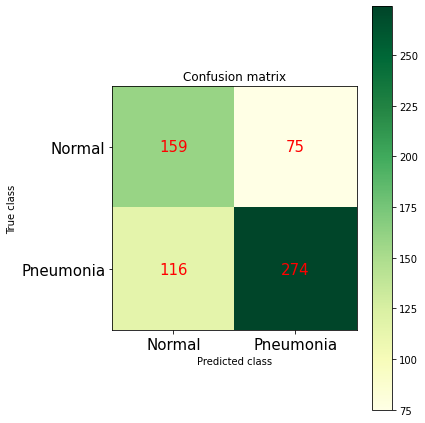

Class | Class Accuracy
Normal | 67.94871794871794
Pneumonia | 70.25641025641026


In [ ]:
# plot confusion matrix for test set

number_classes = 2

# initialise prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad(): # i.e. no point wasting time calculating gradient don't need it here
  for data in testloader: # i.e. iterate over batches of data in the test set
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images) # run the model with the test batch file of 64 images
    _, predicted = torch.max(outputs, 1) # predicted is tensor containing indices of predicted classes

with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1) # predicted is tensor containing indices of predicted classes
    # Append batch prediction results
    predlist=torch.cat([predlist,predicted.view(-1).to(device)])
    lbllist=torch.cat([lbllist,labels.view(-1).to(device)])

# Confusion matrix
predlist = predlist.cpu()
lbllist = lbllist.cpu()
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
conf_mat = np.array(conf_mat)
print(conf_mat)

fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(conf_mat, cmap="YlGn")

# We want to show all ticks...
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
# ... and label them with the respective list entries
ax.set_xticklabels(classes)
ax.set_yticklabels(classes, size = 15)
plt.xlabel('Predicted class')
plt.ylabel('True class')

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax, cmap="YlGn")
cbar.ax.set_ylabel('', rotation=-90, va="bottom", size = 15)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", size = 15)

# Loop over data dimensions and create text annotations 
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="r", size = 15)

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print('Class' + ' | ' + 'Class Accuracy')
for i in range(len(classes)):
  print(classes[i] + ' | ' + str(class_accuracy[i]))



In [ ]:
# test on entire test dataset


correct = 0
total = 0

predicted_master = np.empty(0)
true_master = np.empty(0)

with torch.no_grad(): # i.e. no point wasting time calculating gradient don't need it here
  for data in testloader: # i.e. iterate over batches of data in the test set
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images) # run the model with the test batch file of 64 images
    _, predicted = torch.max(outputs, 1) # predicted is tensor containing indices of predicted classes
    total += labels.size(0) # .size(0) gives the number of rows, .size(1) gives the number of columns
    # here labels is a tensor of size 64, correspondning to 64 images
    # therefore each run of loop adds 64 images that have been analysed
    correct += (predicted == labels).sum().item() # this adds up total number of correct predictions in this batch of 64
    # needed for f1 score
    predicted_master = np.concatenate((predicted_master,predicted.cpu().numpy()),axis=None)
    true_master = np.concatenate((true_master,labels.cpu().numpy()),axis=None)
print('Accuracy of the model of test images: %d %%' % (100 * correct/total))

# F1 score
f1_micro_score = f1_score(true_master, predicted_master, average = 'micro')
print('F1 micro score is ')
print(f1_micro_score)

# Kendall tau score
tau, p_value = stats.kendalltau(true_master, predicted_master)

print('tau is ')
print(tau)

print('p value is ')
print(p_value)

Accuracy of the model of test images: 69 %
F1 micro score is 
0.6923076923076923
tau is 
0.4465073754059537
p value is 
7.590631652249769e-29


In [ ]:
# ROC curve

from sklearn import metrics
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = metrics.roc_curve(true_master, predicted_master, pos_label=1)
auc_score = roc_auc_score(true_master,predicted_master)

# plot curve
plt.figure()
plt.scatter(fpr,tpr,marker = "x")
z = np.polyfit(fpr,tpr, 2)
x = np.linspace(min(fpr),max(fpr),100)
p = np.poly1d(z)
plt.plot(x, p(x))
plt.xlabel('FPR')
plt.ylabel('TPR')
# plot x = y
q = np.poly1d([1,0])
plt.plot(x,q(x),'--')
plt.plot()
plt.show()

print('Area under curve is ' + str(auc_score))


In [ ]:
# accuracy on val set

total = 0
correct = 0

with torch.no_grad(): # i.e. no point wasting time calculating gradient don't need it here
  for data in valloader: # i.e. iterate over batches of data in the test set
    inputs, labels = data[0].to(device), data[1].to(device)
    outputs = model(inputs) # run the model with the test batch file of 64 images
    _, predicted = torch.max(outputs, 1) # predicted is tensor containing indices of predicted classes
    total += labels.size(0) # .size(0) gives the number of rows, .size(1) gives the number of columns
    # here labels is a tensor of size 64, correspondning to 64 images
    # therefore each run of loop adds 64 images that have been analysed
    correct += (predicted == labels).sum().item() # this adds up total number of correct predictions in this batch of 64
    # needed for f1 score
print('Accuracy of the model on validation images: %d %%' % (100 * correct/total))

In [ ]:
# test best model for val set -> on val set

model_save_name = 'model_best_on_val.pt'
path = F"/content/gdrive/My Drive/Week 3/{model_save_name}"
model.load_state_dict(torch.load(path))

# run this model on test and val

# accuracy test

total = 0
correct = 0

with torch.no_grad(): # i.e. no point wasting time calculating gradient don't need it here
  for data in valloader: # i.e. iterate over batches of data in the test set
    inputs, labels = data[0].to(device), data[1].to(device)
    outputs = model(inputs) # run the model with the test batch file of 64 images
    _, predicted = torch.max(outputs, 1) # predicted is tensor containing indices of predicted classes
    total += labels.size(0) # .size(0) gives the number of rows, .size(1) gives the number of columns
    # here labels is a tensor of size 64, correspondning to 64 images
    # therefore each run of loop adds 64 images that have been analysed
    correct += (predicted == labels).sum().item() # this adds up total number of correct predictions in this batch of 64
    # needed for f1 score
print('Accuracy of the model on validation images: %d %%' % (100 * correct/total))


In [ ]:
# test best model on val set --> on the test set

model_save_name = 'model_best_on_val.pt'
path = F"/content/gdrive/My Drive/Week 3/{model_save_name}"
model.load_state_dict(torch.load(path))

# plot confusion matrix
number_classes = 2

# initialise prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cuda')
lbllist=torch.zeros(0,dtype=torch.long, device='cuda')

with torch.no_grad(): # i.e. no point wasting time calculating gradient don't need it here
  for data in testloader: # i.e. iterate over batches of data in the test set
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images) # run the model with the test batch file of 64 images
    _, predicted = torch.max(outputs, 1) # predicted is tensor containing indices of predicted classes

with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1) # predicted is tensor containing indices of predicted classes
    # Append batch prediction results
    predlist=torch.cat([predlist,predicted.view(-1).to(device)])
    lbllist=torch.cat([lbllist,labels.view(-1).to(device)])

# Confusion matrix
predlist = predlist.cpu()
lbllist = lbllist.cpu()
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
conf_mat = np.array(conf_mat)
print(conf_mat)

fig, ax = plt.subplots()
im = ax.imshow(conf_mat, cmap="YlGn")

# We want to show all ticks...
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
# ... and label them with the respective list entries
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.xlabel('Predicted class')
plt.ylabel('True class')

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax, cmap="YlGn")
cbar.ax.set_ylabel('', rotation=-90, va="bottom")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations 
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="r")

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print('Class' + ' | ' + 'Class Accuracy')
for i in range(len(classes)):
  print(classes[i] + ' | ' + str(class_accuracy[i]))



In [ ]:
print(predicted_master)
print(true_master)
print(len(predicted_master))
print(len(true_master))
